## CONLL 2003 数据集
- 链接：https://data.deepai.org/conll2003.zip
- 包括 1,393 篇英文新闻文章和 909 篇德文新闻文章。总共包含4 个实体：PER（人员），LOC（位置），ORG（组织）和 MISC（其他，包括所有其他类型的实体）。
- CoNLL-2003 数据文件包含由单个空格分隔的四列。每个单词都单独占一行，每个句子后面都有一个空行。每行的第一项是单词，第二项是词性 (POS) 标记，第三项是句法块标记，第四项是命名实体标记。块标签和命名实体标签的格式为 I-TYPE，这意味着该单词位于 TYPE 类型的短语内。仅当两个相同类型的短语紧随其后时，第二个短语的第一个单词才会带有标签 B-TYPE 以表明它开始一个新短语。带有标签 O 的单词不是短语的一部分。


### 1. 加载数据集

In [1]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict


max_len = 64

def load_file(path):
    train_sentences = []
    train_labels = []
    with open(path) as f:
        sentence = []
        labels = []
        for line in f:
            line = line.strip()
            if line:
                word, pos, chunk, label = line.split()
                sentence.append(word)
                labels.append(label)
            else:
                if sentence:
                    train_sentences.append(sentence)
                    train_labels.append(labels)
                    sentence = []
                    labels = []
    return train_sentences, train_labels

def build_vocab(sentences, labels):
    tokenizer = get_tokenizer("basic_english")
    def yield_tokens(data):
        for sentence in data:
            yield sentence
    vocab = build_vocab_from_iterator(yield_tokens(sentences), specials=["<pad>", "<unk>"])
    tag_vocab = build_vocab_from_iterator(yield_tokens(labels), specials=["<pad>"])
    return vocab, tag_vocab

class NERDataset(Dataset):
    def __init__(self, sentences, labels, word2idx, tag2idx):
        self.sentences = sentences
        self.labels = labels
        self.word2idx = defaultdict(lambda: word2idx["<unk>"], word2idx)
        self.tag2idx = tag2idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = [self.word2idx[word.lower()] for word in self.sentences[idx]]
        label = [self.tag2idx[tag] for tag in self.labels[idx]]
        return torch.tensor(sentence), torch.tensor(label)

def collate_fn(tag2idx):
    def collate(batch):
        sentences, labels = zip(*batch)
        sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=0)
        labels_padded = pad_sequence(labels, batch_first=True, padding_value=tag2idx["<pad>"])
        return sentences_padded, labels_padded
    return collate

def save_dict(data, path):
    with open(path, 'w') as f:
        json.dump(data, f, indent=2)

train_sentences, train_labels = load_file("./train.txt")
valid_sentences, valid_labels = load_file("./valid.txt")
test_sentences, test_labels = load_file("./test.txt")

vocab, tag_vocab = build_vocab(train_sentences + valid_sentences + test_sentences, train_labels + valid_labels + test_labels)

word2idx = {word: idx for idx, word in enumerate(vocab.get_itos())}
tag2idx = {tag: idx for idx, tag in enumerate(tag_vocab.get_itos())}

save_dict(word2idx, 'word2idx.json')
save_dict(tag2idx, 'idx2Label.json')

train_dataset = NERDataset(train_sentences, train_labels, word2idx, tag2idx)
valid_dataset = NERDataset(valid_sentences, valid_labels, word2idx, tag2idx)
test_dataset = NERDataset(test_sentences, test_labels, word2idx, tag2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn(tag2idx))
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn(tag2idx))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn(tag2idx))


# Example usage:
for batch in train_loader:
    sentences, labels = batch
    print(sentences.shape, labels.shape)
    print("sents: ", sentences)
    print("labels: ", labels)
    break


torch.Size([32, 41]) torch.Size([32, 41])
sents:  tensor([[   34,    14,    36,  ...,     0,     0,     0],
        [  202,     1,     1,  ...,     0,     0,     0],
        [27336,   614,   309,  ...,     0,     0,     0],
        ...,
        [10578,     1, 27613,  ...,     0,     0,     0],
        [    1,  1481,   137,  ...,     0,     0,     0],
        [  174,    39,  1813,  ...,     0,     0,     0]])
labels:  tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 3, 5,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [2, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


### 2. 定义模型结构

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from TorchCRF import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=128):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(num_labels=tagset_size, pad_idx=None)

    def forward(self, sentences, tags=None):
        embeds = self.embedding(sentences)
        lstm_out, _ = self.lstm(embeds)
        lstm_feats = self.hidden2tag(lstm_out)
        if tags is not None:
            loss = -self.crf(lstm_feats, tags, mask=(sentences != 0))
            return loss.mean()
        else:
            tag_seq = self.crf.viterbi_decode(lstm_feats, mask=(sentences != 0))
            return tag_seq

# Hyperparameters
embedding_dim = 100
hidden_dim = 128
vocab_size = len(word2idx)
tagset_size = len(tag2idx)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM_CRF(vocab_size, tagset_size, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("vocab_size: ", vocab_size)
print("tagset_size: ", tagset_size)
print("device: ", device)

vocab_size:  30292
tagset_size:  10
device:  cuda


### 3. 定义训练过程

In [3]:
from collections import Counter


idx2tag = {idx: tag for tag, idx in tag2idx.items()}

def compute_metrics(true_labels, pred_labels, idx2tag):

    labels = [idx2tag[idx] for idx in idx2tag if idx2tag[idx] != "<pad>"]

    true_counter = Counter(true_labels)
    pred_counter = Counter(pred_labels)
    correct_counter = Counter([pred for true, pred in zip(true_labels, pred_labels) if true == pred])

    metrics = {}
    for label in labels:
        true_count = true_counter[tag2idx[label]]
        pred_count = pred_counter[tag2idx[label]]
        correct_count = correct_counter[tag2idx[label]]

        precision = correct_count / pred_count if pred_count > 0 else 0
        recall = correct_count / true_count if true_count > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[label] = {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    return metrics


def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    with torch.no_grad():
        for sentences, tags in data_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            loss = model(sentences, tags)
            total_loss += loss.item()
            preds = model(sentences)
            
            for pred, true in zip(preds, tags):
                all_preds.extend(pred)
                all_labels.extend(true[:len(pred)].tolist())

    return total_loss / len(data_loader), all_preds, all_labels



def train(model, train_loader, valid_loader, idx_to_tag, num_epochs=10):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for sentences, tags in train_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            model.zero_grad()
            loss = model(sentences, tags)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = model(sentences)
            for pred, tag in zip(preds, tags.cpu().numpy()):
                correct_predictions += sum(p == t for p, t in zip(pred, tag[:len(pred)]))
                total_predictions += len(pred)

        train_losses.append(total_loss / len(train_loader))
        train_accuracy = correct_predictions / total_predictions
        train_accuracies.append(train_accuracy)
        print(f'Epoch {epoch + 1}, Train Loss: {(total_loss / len(train_loader)):.6f}, Train Accuracy: {train_accuracy:.4f}')

        valid_loss, valid_preds, valid_labels = evaluate(model, valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append((np.array(valid_labels) == np.array(valid_preds)).mean())
        metrics = compute_metrics(valid_labels, valid_preds, idx_to_tag)
        print(f'Epoch {epoch + 1}, Validation Metrics:')
        for label, metric in metrics.items():
            print(f"  Label: {label}")
            print(f"  Precision: {metric['precision']:.4f}")
            print(f"  Recall: {metric['recall']:.4f}")
            print(f"  F1-Score: {metric['f1']:.4f}\n")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


train_losses, valid_losses, train_accuracies, valid_accuracies = train(model, train_loader, valid_loader, idx2tag, num_epochs=20)


Epoch 1, Train Loss: 6.807011, Train Accuracy: 0.8602
Epoch 1, Validation Metrics:
  Label: O
  Precision: 0.9648
  Recall: 0.9780
  F1-Score: 0.9714

  Label: B-LOC
  Precision: 0.3380
  Recall: 0.2629
  F1-Score: 0.2958

  Label: B-PER
  Precision: 0.3446
  Recall: 0.6140
  F1-Score: 0.4415

  Label: B-ORG
  Precision: 0.2152
  Recall: 0.3356
  F1-Score: 0.2622

  Label: I-PER
  Precision: 0.7483
  Recall: 0.6641
  F1-Score: 0.7037

  Label: I-ORG
  Precision: 0.2400
  Recall: 0.0160
  F1-Score: 0.0300

  Label: B-MISC
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

  Label: I-MISC
  Precision: 1.0000
  Recall: 0.0029
  F1-Score: 0.0058

  Label: I-LOC
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Epoch 2, Train Loss: 4.797609, Train Accuracy: 0.8844
Epoch 2, Validation Metrics:
  Label: O
  Precision: 0.9751
  Recall: 0.9755
  F1-Score: 0.9753

  Label: B-LOC
  Precision: 0.3555
  Recall: 0.3669
  F1-Score: 0.3611

  Label: B-PER
  Precision: 0.4349
  Recall: 0.7

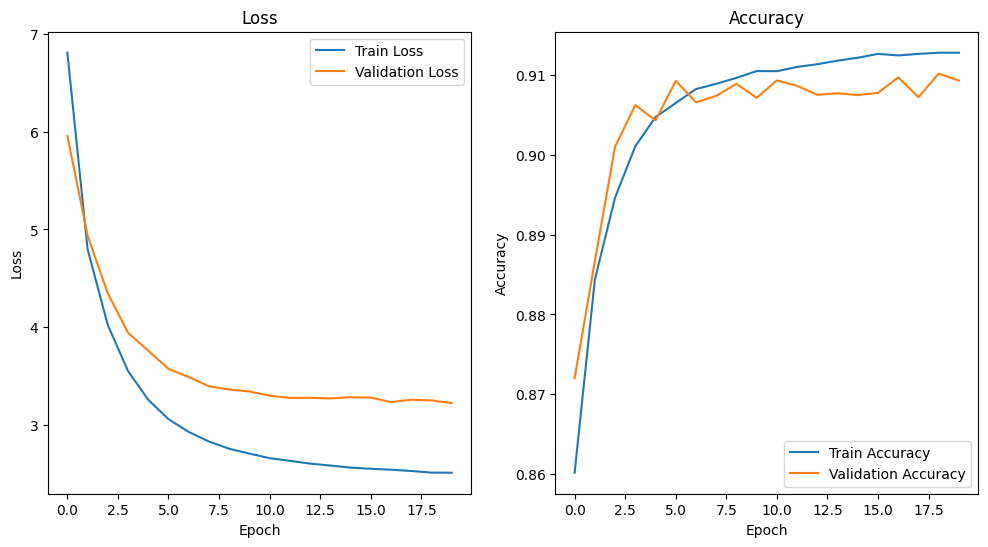

In [6]:
import matplotlib.pyplot as plt

# 画Loss曲线图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 画准确度图
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [7]:


# 测试集评估模型效果
test_loss, test_preds, test_labels = evaluate(model, test_loader)
test_metrics = compute_metrics(test_labels, test_preds, idx2tag)
print("Test Metrics:")
for label, metric in test_metrics.items():
    print(f"  Label: {label}")
    print(f"  Precision: {metric['precision']:.4f}")
    print(f"  Recall: {metric['recall']:.4f}")
    print(f"  F1-Score: {metric['f1']:.4f}\n")

Test Metrics:
  Label: O
  Precision: 0.9859
  Recall: 0.9641
  F1-Score: 0.9749

  Label: B-LOC
  Precision: 0.3641
  Recall: 0.6481
  F1-Score: 0.4662

  Label: B-PER
  Precision: 0.7143
  Recall: 0.6246
  F1-Score: 0.6664

  Label: B-ORG
  Precision: 0.4918
  Recall: 0.4311
  F1-Score: 0.4594

  Label: I-PER
  Precision: 0.7037
  Recall: 0.9369
  F1-Score: 0.8037

  Label: I-ORG
  Precision: 0.4382
  Recall: 0.4455
  F1-Score: 0.4418

  Label: B-MISC
  Precision: 0.6016
  Recall: 0.2194
  F1-Score: 0.3215

  Label: I-MISC
  Precision: 0.4553
  Recall: 0.5417
  F1-Score: 0.4947

  Label: I-LOC
  Precision: 0.5135
  Recall: 0.4436
  F1-Score: 0.4760

